In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, classification_report)

In [27]:
data = load_breast_cancer()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

In [28]:
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [29]:
y.head(5)

,0
0,0
1,0
2,0
3,0
4,0


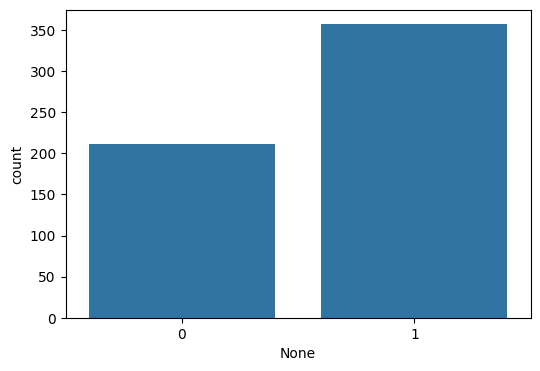

In [30]:
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.show()

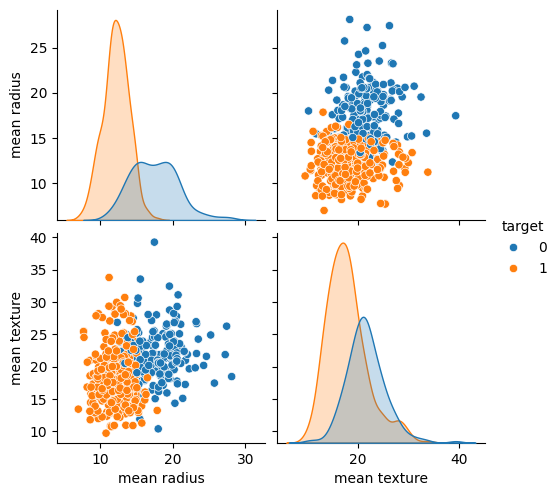

In [31]:
df = pd.DataFrame(X, columns=data.feature_names)
df['target']=y

sns.pairplot(df[['mean radius', 'mean texture', 'target']], hue='target')
plt.show()

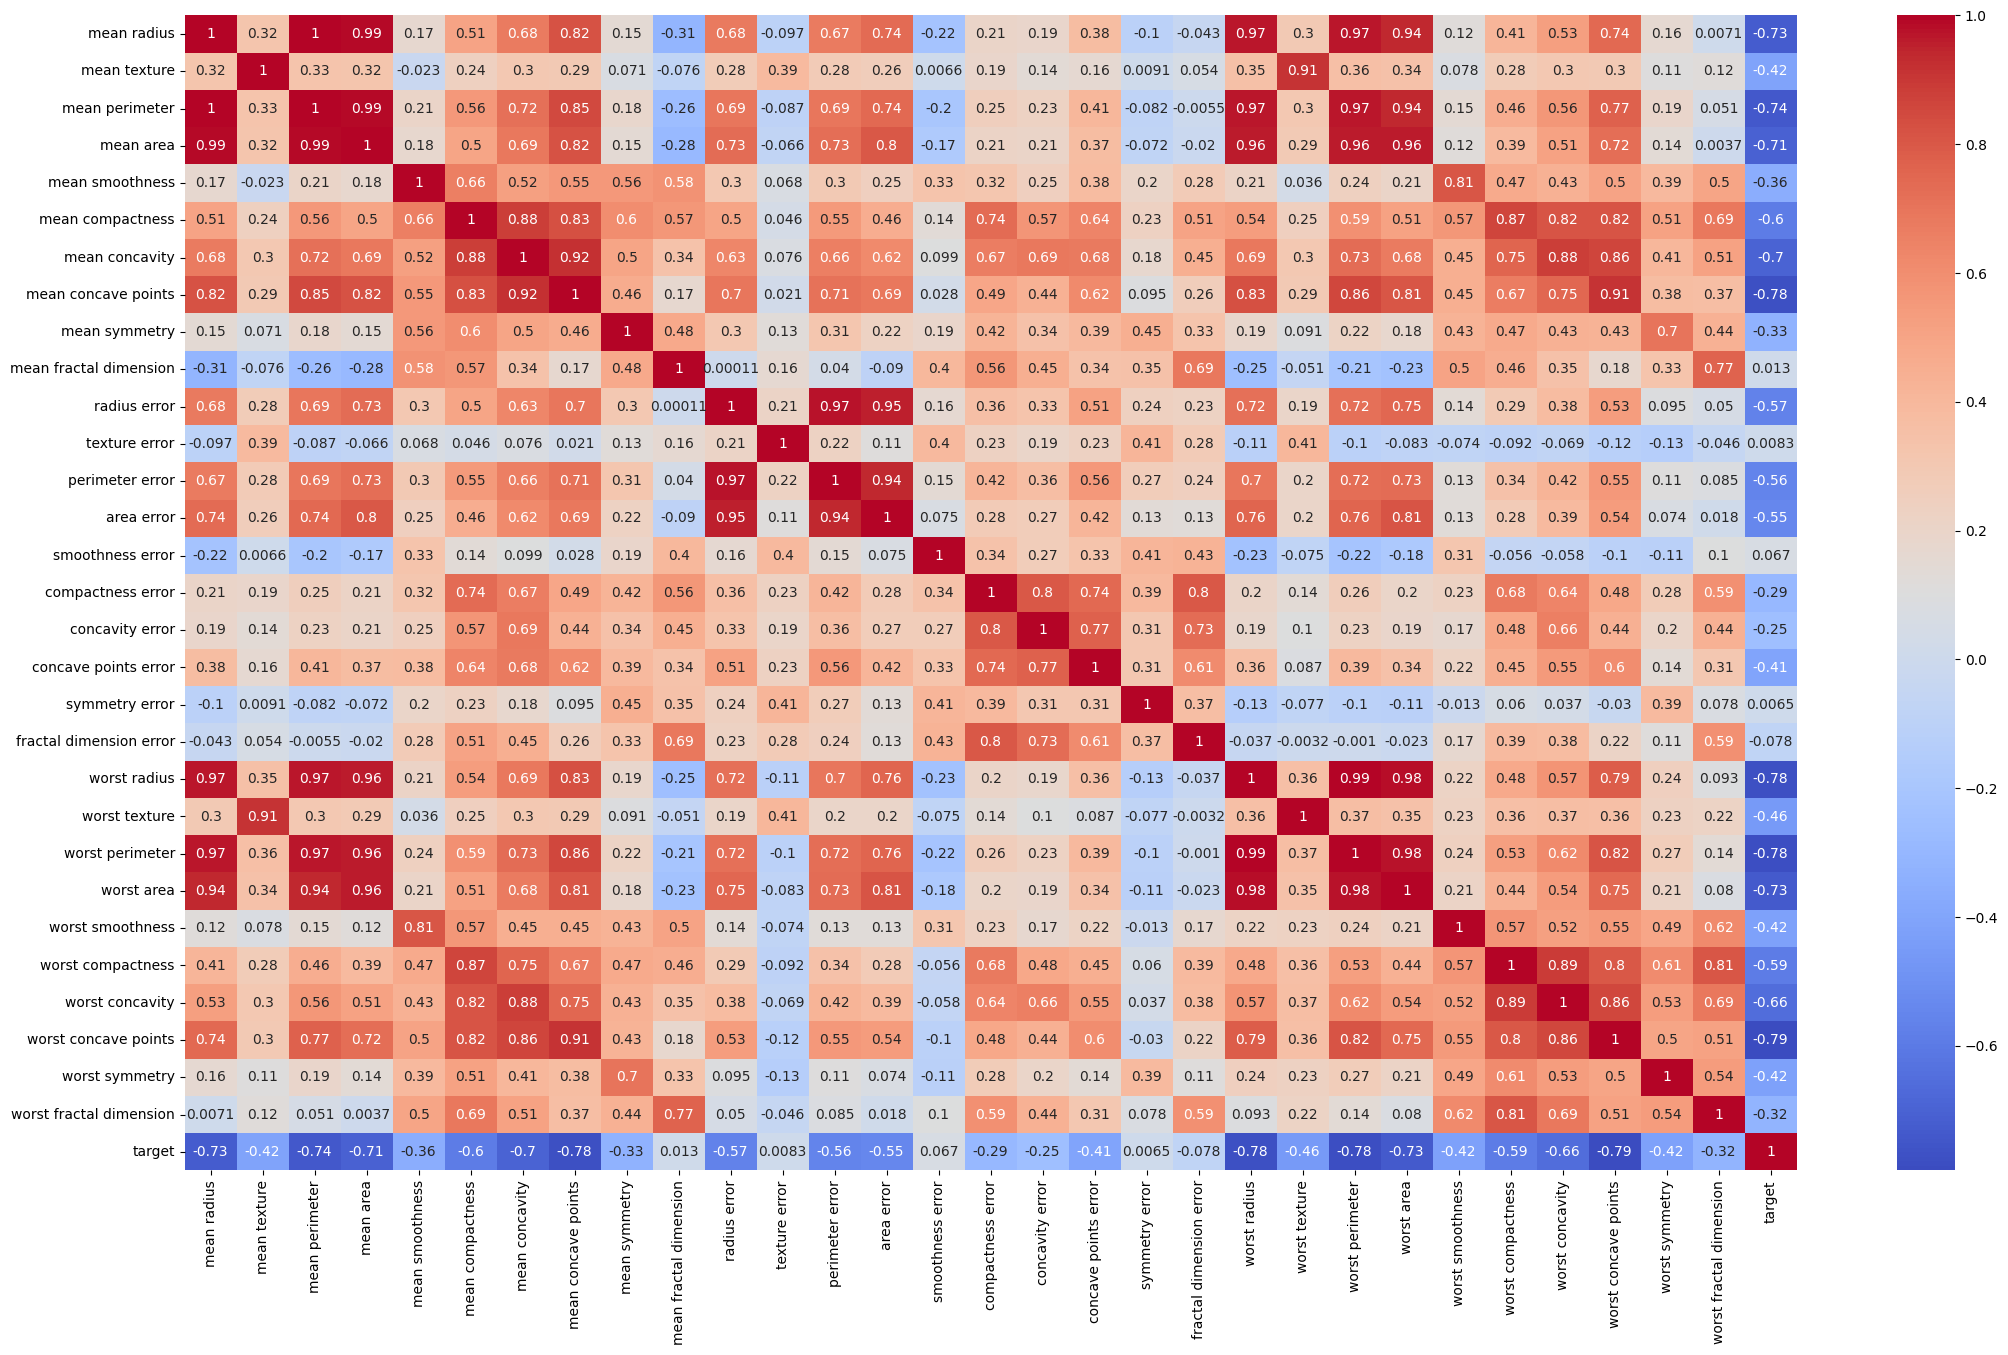

In [32]:
plt.figure(figsize=(26,15))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm')
plt.show()

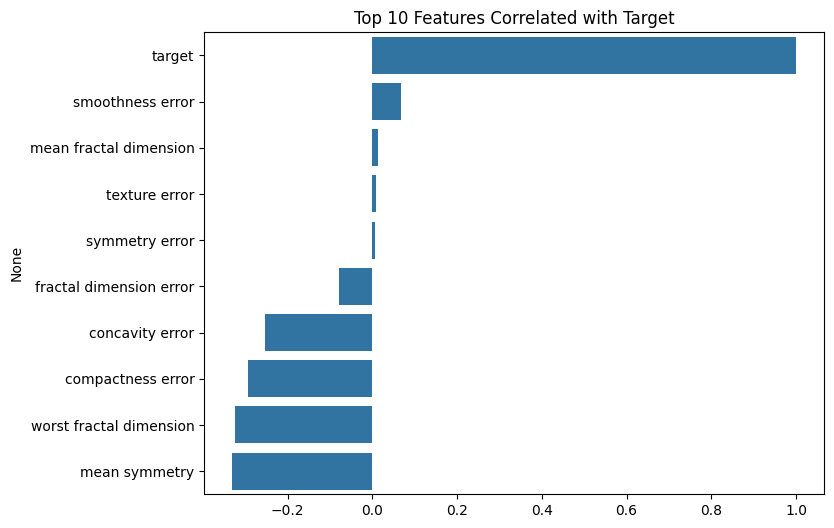

In [33]:
# Correlation with target
corr_with_target = df.corr()['target'].sort_values(ascending=False)

# Visualize top correlations
plt.figure(figsize=(8,6))
sns.barplot(x=corr_with_target.values[:10], y=corr_with_target.index[:10])
plt.title("Top 10 Features Correlated with Target")
plt.show()

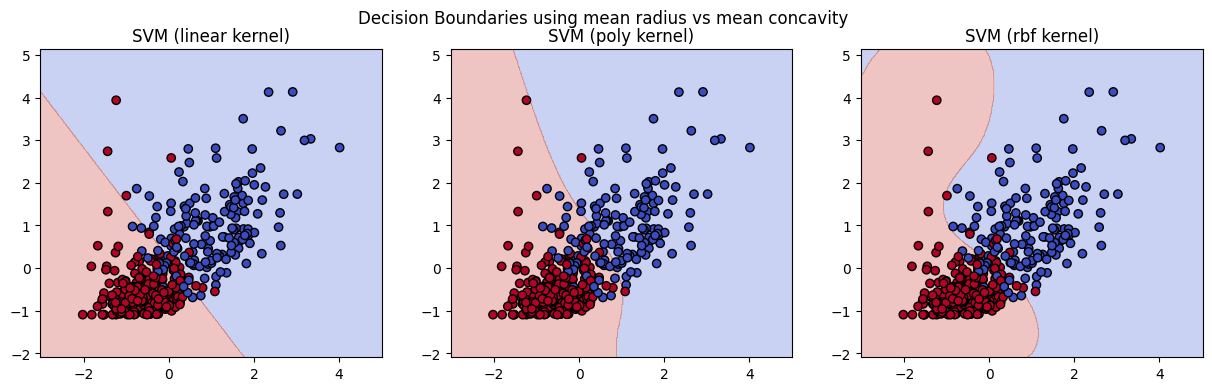

In [34]:

import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

feature1 = 'mean radius'
feature2 = 'mean concavity'



# Prepare data
X = df[[feature1, feature2]].values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define kernels
kernels = ['linear', 'poly', 'rbf']

plt.figure(figsize=(15, 4))

for i, kernel in enumerate(kernels):
    # Fit SVM
    svm = SVC(kernel=kernel, degree=3, C=1, gamma='scale')
    svm.fit(X_train_scaled, y_train)

    # Create mesh grid
    x_min, x_max = X_train_scaled[:, 0].min() - 1, X_train_scaled[:, 0].max() + 1
    y_min, y_max = X_train_scaled[:, 1].min() - 1, X_train_scaled[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))

    # Predict on grid
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot
    plt.subplot(1, 3, i+1)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, cmap='coolwarm', edgecolors='k')
    plt.title(f"SVM ({kernel} kernel)")

plt.suptitle(f"Decision Boundaries using {feature1} vs {feature2}")
plt.show()



# Metrics Evaluation

In [35]:
def evaluate_metric(y_test, y_pred, y_prob=None):
  metrics = {
      "accuracy": accuracy_score(y_test,y_pred),
      "precision": precision_score(y_test, y_pred),
      "recall": recall_score(y_test,y_pred),
      "f1": f1_score(y_test, y_pred)
  }

  if y_prob is not None:
        metrics["roc_auc"] = roc_auc_score(y_test, y_prob)
  else:
        metrics["roc_auc"] = None
  return metrics

In [36]:
baseline_results = {}


for kernel in kernels:
  pipeline = Pipeline([
      ('scaler', StandardScaler()),
      ('svc', SVC(kernel=kernel, degree=3, C=1.0, gamma='scale',probability=True, random_state=42))
  ])

  pipeline.fit(X_train, y_train)
  y_pred = pipeline.predict(X_test)
  y_proba = pipeline.predict_proba(X_test)[:, 1]

  baseline_results[kernel] = evaluate_metric(y_test, y_pred, y_proba)
  print(f"\n=== Kernel: {kernel} ===")
  print(pd.Series(baseline_results[kernel]))
  print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
  print("Classification report:\n", classification_report(y_test, y_pred, digits=4))


=== Kernel: linear ===
accuracy     0.921053
precision    0.943662
recall       0.930556
f1           0.937063
roc_auc      0.974206
dtype: float64
Confusion Matrix:
 [[38  4]
 [ 5 67]]
Classification report:
               precision    recall  f1-score   support

           0     0.8837    0.9048    0.8941        42
           1     0.9437    0.9306    0.9371        72

    accuracy                         0.9211       114
   macro avg     0.9137    0.9177    0.9156       114
weighted avg     0.9216    0.9211    0.9212       114


=== Kernel: poly ===
accuracy     0.868421
precision    0.827586
recall       1.000000
f1           0.905660
roc_auc      0.969577
dtype: float64
Confusion Matrix:
 [[27 15]
 [ 0 72]]
Classification report:
               precision    recall  f1-score   support

           0     1.0000    0.6429    0.7826        42
           1     0.8276    1.0000    0.9057        72

    accuracy                         0.8684       114
   macro avg     0.9138    0.8214  

In [37]:
sorted_by_f1 = sorted(baseline_results.items(), key=lambda kv: kv[1]['f1'], reverse=True)
top_kernels = [sorted_by_f1[0][0]]

In [38]:
if len(sorted_by_f1) > 1:
  top_kernels.append(sorted_by_f1[1][0])

print("\n Top kernals to tune:", top_kernels)




 Top kernals to tune: ['linear', 'rbf']


# Tuning Top Kernels

Using GridSearch per selected kernels (separate grids for poly vs others)

In [45]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_estimators={}

for kernel in top_kernels:
  if kernel == 'poly':
    param_grid = {
        'svc__C': [0.1,1,10],
        'svc__degree': [2,3,4],
        'svc__gama': ['scale', 0.01, 0.1],
    }
  else :
    param_grid = {
        'svc__C': [0.1,1,10],
        'svc__gamma': ['scale', 0.01, 0.1] if kernel == 'rbf' else ['scale'],
    }

  pipeline = Pipeline([
      ('scaler' , StandardScaler()),
      ('svc', SVC(kernel=kernel, probability=True, random_state=42))
  ])

  grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1)
  grid.fit(X_train, y_train)
  print(f"\nGridSearch best for kernel = {kernel}: {grid.best_params_}  best_cv_f1 = {grid.best_score_:.4f}\n")
  best_estimators[kernel] = grid.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits

GridSearch best for kernel = linear: {'svc__C': 0.1, 'svc__gamma': 'scale'}  best_cv_f1 = 0.9306

Fitting 5 folds for each of 9 candidates, totalling 45 fits

GridSearch best for kernel = rbf: {'svc__C': 10, 'svc__gamma': 'scale'}  best_cv_f1 = 0.9389



# Final Evaluation of best estimator on test set

In [46]:
final_results = {}
for kernel, model in best_estimators.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    final_results[kernel] = evaluate_metric(y_test, y_pred, y_proba)
    print(f"\n--- Final eval for kernel: {kernel} ---")
    print(pd.Series(final_results[kernel]))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification report:\n", classification_report(y_test, y_pred, digits=4))

# 7. Pick best final model by F1 and show it
best_kernel_final = max(final_results.items(), key=lambda kv: kv[1]['f1'])[0]
print("\nBest final kernel (by test F1):", best_kernel_final)


--- Final eval for kernel: linear ---
accuracy     0.921053
precision    0.931507
recall       0.944444
f1           0.937931
roc_auc      0.977183
dtype: float64
Confusion Matrix:
 [[37  5]
 [ 4 68]]
Classification report:
               precision    recall  f1-score   support

           0     0.9024    0.8810    0.8916        42
           1     0.9315    0.9444    0.9379        72

    accuracy                         0.9211       114
   macro avg     0.9170    0.9127    0.9147       114
weighted avg     0.9208    0.9211    0.9208       114


--- Final eval for kernel: rbf ---
accuracy     0.903509
precision    0.917808
recall       0.930556
f1           0.924138
roc_auc      0.973876
dtype: float64
Confusion Matrix:
 [[36  6]
 [ 5 67]]
Classification report:
               precision    recall  f1-score   support

           0     0.8780    0.8571    0.8675        42
           1     0.9178    0.9306    0.9241        72

    accuracy                         0.9035       114
   mac